Ouvrir ce notebook dans :
<a href="https://colab.research.google.com/github/joanglaunes/deep_learning_image/blob/main/CircleSquare-autoencoder.ipynb" target="_blank">Google Colab</a>
ou
<a href="https://rosenblatt.ens.math-info.univ-paris5.fr/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fjoanglaunes%2Fdeep_learning_image&urlpath=tree%2Fdeep_learning_image%2FCircleSquare-autoencoder.ipynb&branch=main" target="_blank">Rosenblatt</a>

Autoencoder dérivé de l'exemple "circlesquare"

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

Fonction pour créer les données images : la fonction CreateData renvoie un tenseur I de taille Nx1x32x32 contenant les images et un vecteur L contenant les classes (0 ou 1)

In [ ]:
def CreateData(N):
    M = 32
    I = np.zeros([N,1,M,M])
    L = np.zeros(N)
    ech = np.linspace(0,1,M)
    X,Y = np.meshgrid(ech,ech)
    for k in range(N):
        r = 1/8+np.random.rand(1)/8 # random radius
        c = r+(1-2*r)*np.random.rand(2,1) # random center position
        if np.random.rand(1)<.5:
            # circle
            I[k,0,:,:] = ((X-c[0])**2+(Y-c[1])**2) < r**2
            L[k] = 0
        else:
            # square
            I[k,0,:,:] = np.maximum(np.abs(X-c[0]),np.abs(Y-c[1])) < r
            L[k] = 1
    return I, L

On crée 2500 images et on affiche les 5 premières :

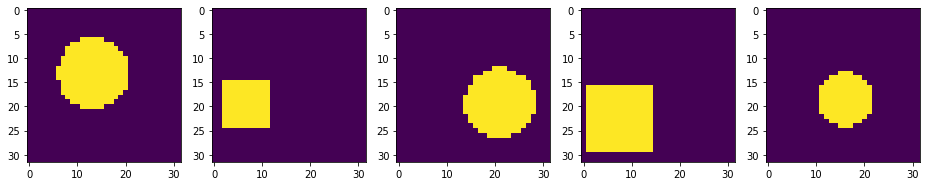

In [ ]:
N = 2500
I, L = CreateData(N)
plt.rcParams['figure.figsize'] = [16, 8]
for k in range(5):
    plt.subplot(1, 5, k+1)
    plt.imshow(np.squeeze(I[k,0,:,:]))

plt.show()

On convertit les données en tenseurs PyTorch :

In [ ]:
I = torch.from_numpy(I.astype('float32'))
L = torch.from_numpy(L.astype('long'))

In [ ]:
N = len(L)
batch_size = 100
nbatch = N//batch_size
print(nbatch)

25


A présent on définit les variables du réseau : deux filtres de convolution fa et fb et une matrice m pour la partie encodeage ; deux filtres fab, fbd, et une matrice md pour la prtie décodage

On ajoute requires_grad=True pour indiquer qu'on va avoir besoin de calculer le gradient de la fonction de coût par rapport à ces variables.

In [ ]:
dimcode = 10

fa = torch.randn(16,1,5,5,requires_grad=True)
fb = torch.randn(32,16,5,5,requires_grad=True)
m = torch.randn(8*8*32,dimcode,requires_grad=True)

md = torch.randn(dimcode,8*8*32,requires_grad=True)
fbd = torch.randn(32,16,5,5,requires_grad=True)
fad = torch.randn(16,1,5,5,requires_grad=True)

On définit maintenant la fonction encodage et la fonction décodage, chacune comportant 3 couches. Le réseau final est la compositionde l'encodeur et du décodeur.

In [ ]:
def encoder(I):
    # first layer
    out = F.conv2d(I, fa, padding=2)
    out = nn.BatchNorm2d(16, affine=False)(out)
    out = torch.relu(out)
    out = F.max_pool2d(out,2,stride=2)
    # second layer
    out = F.conv2d(out, fb, padding=2)
    out = nn.BatchNorm2d(32, affine=False)(out)
    out = torch.relu(out)
    out = F.max_pool2d(out,2,stride=2)
    # flatten
    out = out.reshape(out.size(0), -1)
    # third layer
    out = out.mm(m)
    return out

def decoder(code):
    # first layer
    out = code.mm(md)
    out = out.reshape((-1,32,8,8))
    # second layer
    out = torch.relu(out)
    out = nn.BatchNorm2d(32, affine=False)(out)
    out = F.conv_transpose2d(out, fbd, stride=2, padding=2, output_padding=1)
    # third layer
    out = torch.relu(out)
    out = nn.BatchNorm2d(16, affine=False)(out)
    out = F.conv_transpose2d(out, fad, stride=2, padding=2, output_padding=1)
    out = F.sigmoid(out)
    return out

def mycnn(I):
    code = encoder(I)
    out = decoder(code)
    return out

On passe à présent à l'entraînement du réseau :

In [ ]:
niter = 10
lossrec = np.zeros(niter*nbatch)
learning_rate = 1e-1
optimizer = torch.optim.Adam([fa,fb,m,fad,fbd,md], lr=learning_rate)
for t in range(niter):
    for k in range(nbatch):
        Ik = I[range(k*batch_size,(k+1)*batch_size),:]
        optimizer.zero_grad()
        out = mycnn(Ik)
        loss = nn.BCELoss()(out,Ik)
        loss.backward()
        optimizer.step()
        lossrec[k+t*nbatch] = loss.item()
        if k % 10 == 0:
            print(t,k,lossrec[k+t*nbatch])

/home/glaunes/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 0 3.612405300140381
0 10 0.43575888872146606
0 20 0.1673699915409088
1 0 0.13132697343826294
1 10 0.0917806401848793
1 20 0.06980954110622406
2 0 0.06426458805799484
2 10 0.058235302567481995
2 20 0.05110914632678032
3 0 0.04998434707522392
3 10 0.04858434200286865
3 20 0.04357731342315674
4 0 0.044950976967811584
4 10 0.04466107860207558
4 20 0.03777565062046051
5 0 0.039711371064186096
5 10 0.04064096510410309
5 20 0.0338783860206604
6 0 0.035953108221292496
6 10 0.03730391338467598
6 20 0.030590659007430077
7 0 0.03423430398106575
7 10 0.03561120852828026
7 20 0.029052812606096268
8 0 0.03380321338772774
8 10 0.0346987210214138
8 20 0.02789023332297802
9 0 0.03498304262757301
9 10 0.035129841417074203
9 20 0.02829516865313053


Le réseau est entraîné ; on affiche 5 images d'entrée et la sortie correspondante de l'autoencodeur. On voit que celui-ci a bien encodé position et taille des objets, mais pas plus.

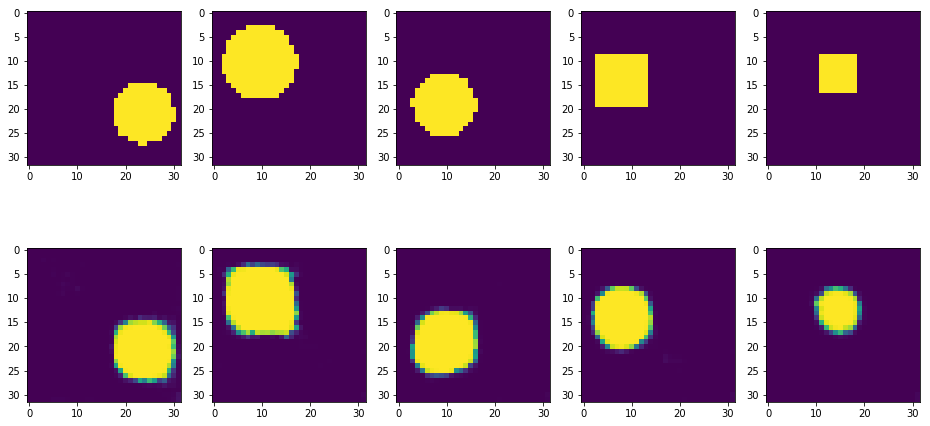

In [ ]:
plt.rcParams['figure.figsize'] = [16, 8]
out = mycnn(I)
for k in range(5):
    plt.subplot(2, 5, k+1)
    plt.imshow(np.squeeze(I[k,0,:,:]))
for k in range(5):
    plt.subplot(2, 5, k+6)
    plt.imshow(np.squeeze(out[k,0,:,:].data))
plt.show()

<br>
<br>
On affiche des images de sorties correspondant à des codes aléatoires :

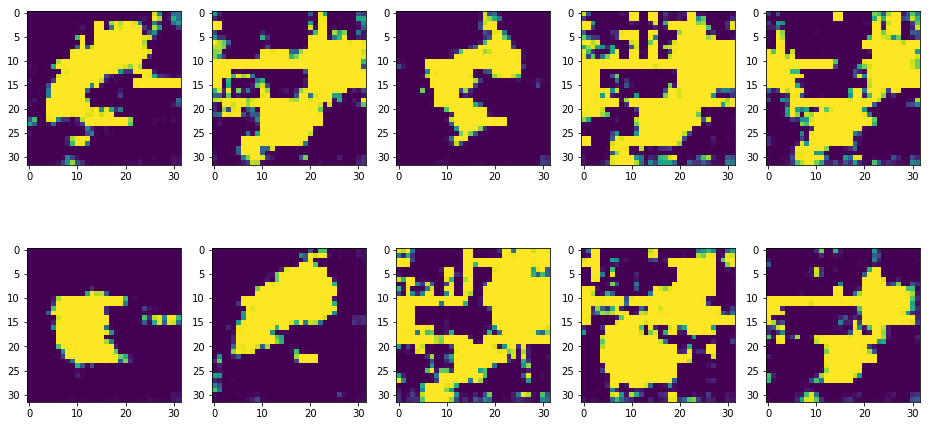

In [ ]:
code = torch.rand(10,dimcode)
out = decoder(code)
out = out.reshape(10,32,32)
plt.rcParams['figure.figsize'] = [16, 8]
for k in range(10):
    plt.subplot(2, 5, k+1)
    plt.imshow(np.squeeze(out.data[k,:,:].cpu()))

<br>
<br>
<br>
A présent on va effectuer une moyenne dans l'espace des codes et observer l'image correspondante après décodage.
On compare avec la moyenne des images sans encodage.

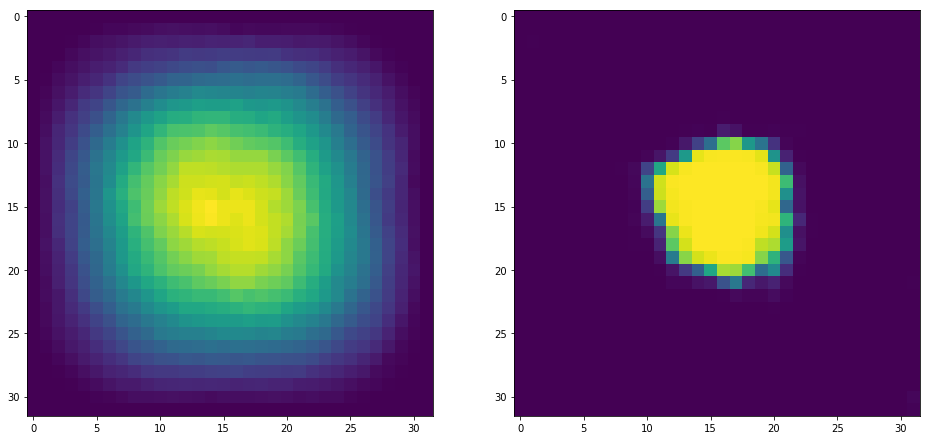

In [ ]:
Icircle = I[L==0,:,:,:]
I_mean_circle = torch.mean(Icircle,dim=0)
out = encoder(Icircle)
code_circle_mean = torch.mean(out,dim=0).reshape(1,-1)
I_mean_circle_autoencoder = decoder(code_circle_mean)
plt.subplot(1,2,1)
plt.imshow(np.squeeze(I_mean_circle.data.cpu()))
plt.subplot(1,2,2)
plt.imshow(np.squeeze(I_mean_circle_autoencoder.data[0,:,:].cpu()))
plt.show()